TODO list:

- test communication with all servos at once
- plot angles/samples

In [1]:
from __future__ import division

import serial
import numpy as np
import scipy.signal as signal
from collections import defaultdict
import Queue
import time
import threading
import matplotlib.pyplot as plt
%matplotlib inline

from rtlsdr import RtlSdr, librtlsdr, helpers

In [2]:
from utils import *

In [22]:
class Servos:
    """
    Commands servos via serial port
    """
    
    def __init__(self, num_servos, port, baudrate=115200):
        self.num_servos = num_servos
        self.serial = serial.Serial(port, baudrate=baudrate, timeout=1.)
        
        self.min_angle = -np.pi/3.
        self.max_angle = np.pi/3.
        
        self.read_queues = [Queue.Queue() for _ in xrange(self.num_servos)]
        self.read_stop = False
        self.read_serial_thread = threading.Thread(target=self.read_serial_run, args=())
        self.read_serial_thread.daemon = True
        self.read_serial_thread.start()
    
    def set_angle(self, ith, angle, speed, block=True):
        s = '{0} {1:.3f} {2:.3f}\n'.format(ith, angle, speed)
        for char in s:
            self.serial.write(char)
            time.sleep(0.001)
            
        if block:
            q = self.read_queues[ith]
            with q.mutex:
                q.queue.clear()
            return self.get_angle_and_time(ith)
        
    def read_serial_run(self):
        while not self.read_stop:
            #print('read_serial_run: waiting for readline...')
            #line = self.read_line()
            try:
                line = self.serial.readline()
            except Exception:
                time.sleep(0.001)
                continue
            if len(line) == 0:
                continue
            servo_num, angle, t = line.split('_')

            servo_num = int(servo_num)
            angle = float(angle)
            t = float(t)

            #print('servo_num: {0}'.format(servo_num))
            #print('angle: {0}'.format(angle))
            #print('t: {0}\n'.format(t))
            self.read_queues[servo_num].put((angle, t))
            
    def get_angle_and_time(self, ith):
        return self.read_queues[ith].get()
    
if 'servos' in locals():
    servos.read_stop = True
    time.sleep(0.1)
servos = Servos(3, '/dev/ttyACM0')

In [4]:
#####################
# Test ServosSerial #
#####################

speed = 1.0
ith = 0

t0 = time.time()
a0, _ = servos.set_angle(ith, servos.min_angle, speed)
a1, _ = servos.set_angle(ith, servos.max_angle, speed)
t1 = time.time()

print('[a0, a1]: [{0}, {1}]'.format(a0, a1))
print('Elapsed: {0}'.format(t1 - t0))

[a0, a1]: [-1.03, 1.033]
Elapsed: 3.15360808372


In [3]:
class SDRs:
    """
    Functionality for multiple SDRs (non-blocking)
    """
    def __init__(self, rtlsdr_devs, fc, fs=2.4e6, gain=1.0):
        self.rtlsdr_devs = rtlsdr_devs
        self.rtlsdrs = [None]*len(self.rtlsdr_devs)
        
        self.fc = fc
        self.fs = fs
        self.gain = gain
            
        # for asynchronous reads
        self.read_queues = [Queue.Queue() for _ in self.rtlsdr_devs]
        self.read_run_flags = [False]*len(self.rtlsdr_devs)
        self.read_is_stoppeds = [False]*len(self.rtlsdr_devs)
        self.read_threads = [None]*len(self.rtlsdr_devs)
        
        for ith, rtlsdr_dev in enumerate(self.rtlsdr_devs):
            if rtlsdr_dev is None:
                continue
            
            self.rtlsdrs[ith] = RtlSdr(rtlsdr_dev)
            self.rtlsdrs[ith].sample_rate = self.fs
            self.rtlsdrs[ith].center_freq = self.fc
            self.rtlsdrs[ith].gain = self.gain

            self.read_threads[ith] = threading.Thread(target=self.run, args=(ith,))
            self.read_threads[ith].daemon = True
            self.read_threads[ith].start()
            
    def set_gains(self, gain):
        self.gain = gain
        for rtlsdr in self.rtlsdrs:
            if rtlsdr is not None:
                rtlsdr.gain = self.gain
    
    def start_read(self, ith):
        if self.read_run_flags[ith] or \
            self.rtlsdr_devs[ith] is None or \
            self.read_is_stoppeds[ith]:
            return False
        
        self.read_run_flags[ith] = True
        return True
        
    def stop_read(self, ith):
        """ Returns maxPower of samples gathered """
        if not self.read_run_flags[ith] or self.rtlsdr_devs[ith] is None:
            return None
        
        self.read_run_flags[ith] = False
        
        x = np.array([])
        while not self.read_queues[ith].empty():
            x = np.append(x, self.read_queues[ith].get())
        return np.array(x)
    
    def run(self, ith, M=32*1024): # 64 * 1024
        def read_cb(samples, q):
            if self.read_run_flags[ith]:
                try:
                    q.put(maxPower(samples, N=4*1024))
                    #q.put(samples[::M])
                except Exception as e:
                    print('read_cb exception: {0}'.format(e))
            
        try:
            self.rtlsdrs[ith].read_samples_async(read_cb, M, context=self.read_queues[ith])
        except Exception as e:
            print(e)
        self.read_is_stoppeds[ith] = True
    
num_sdrs = 3
fc = 145.6e6

dev_cnt = librtlsdr.rtlsdr_get_device_count()
rtlsdr_devs = [i if i < dev_cnt else None for i in xrange(num_sdrs)]
sdrs = SDRs(rtlsdr_devs, fc)

In [6]:
#############
# Test SDRs #
#############
print('Start reading')
sdrs.start_read(0)
print('Sleeping...')
time.sleep(1)
print('Stop reading')
x = np.array([])
start = time.time()
x = sdrs.stop_read(0)
print('len(x): {0}'.format(len(x)))
print('time to stop: {0}'.format(time.time() - start))

Start reading
Sleeping...
Stop reading
len(x): 2376
time to stop: 0.0364639759064


In [23]:
class ServosSDRs:
    """
    Command servos and read from SDRs
    """
    def __init__(self, servos, sdrs):
        self.servos = servos
        self.sdrs = sdrs
        
        self.default_speed = np.pi/3.
        
        self.run_flags = [False]*self.servos.num_servos
        self.is_stoppeds = [False]*self.servos.num_servos
        self.threads = [None]*self.servos.num_servos
        
        self.angles_and_maxpowers = [Queue.Queue() for _ in xrange(self.servos.num_servos)]
        
    def start(self, ith, speed=None, run_on_stop_read=lambda:None):
        if self.run_flags[ith]:
            return
        
        q = self.angles_and_maxpowers[ith]
        with q.mutex:
            q.queue.clear()
        
        self.run_flags[ith] = True
        self.threads[ith] = threading.Thread(target=self.run, args=(ith,speed,run_on_stop_read,))
        self.threads[ith].daemon = True
        self.threads[ith].start()                 
    
    def stop(self, ith):
        if not self.run_flags[ith]:
            return
        
        self.run_flags[ith] = False
        
        while not self.is_stoppeds[ith]:
            time.sleep(0.2)
        self.is_stoppeds[ith] = False
        
    def run(self, ith, speed=None, run_on_stop_read=lambda:None):
        """ run_on_stop_read for things like plotting """
        speed = self.default_speed if speed is None else speed
        num_exceptions = 0
        
        curr_angle = self.servos.min_angle
        self.servos.set_angle(ith, curr_angle, speed)
        des_angle = self.servos.max_angle
        
        while self.run_flags[ith]:
            try:
                self.sdrs.start_read(ith)
                angle, t = self.servos.set_angle(ith, des_angle, speed)
                mp = self.sdrs.stop_read(ith)
                
                if mp is not None:
                    angles = np.linspace(curr_angle, des_angle, len(mp))
                    self.angles_and_maxpowers[ith].put([angles, mp])
                
                curr_angle, des_angle = des_angle, curr_angle
                run_on_stop_read()
            except Exception as e:
                num_exceptions += 1
                print('ServosSdr.run exception: {0}'.format(e))
        
                if num_exceptions > 1:
                    break
        
        self.is_stoppeds[ith] = True
        self.servos.set_angle(ith, 0, 0, block=False)
        
    def get_angles_and_maxpowers(self, ith):
        """ For ith sdr, return oldest angle/sample if exists, else None """
        if not self.angles_and_maxpowers[ith].empty():
            return self.angles_and_maxpowers[ith].get()
            
servos_sdrs = ServosSDRs(servos, sdrs)

In [27]:
###################
# Test ServosSDRs #
###################

sdrs.set_gains(0.1)

ham = serial.Serial('/dev/ttyUSB0')
ham.setDTR(0)

try:
    p.terminate()
except:
    pass
p = pyaudio.PyAudio()
Qout = play_pure_tone_continuously(p, ham, 2000., mag=0.5)

ith = 0
servos_sdrs.start(ith, speed=np.pi/5.)

print('Press enter to stop')
raw_input()

servos_sdrs.stop(ith)     
ham.setDTR(0)
Qout.put("KEYOFF")
Qout.put("EOT")
p.terminate()

angles_and_maxpowers0 = list()
a_and_mp = servos_sdrs.get_angles_and_maxpowers(0)
while a_and_mp is not None:
    angles_and_maxpowers0.append(a_and_mp)
    a_and_mp = servos_sdrs.get_angles_and_maxpowers(0)
print('rotations: {0}'.format(len(angles_and_maxpowers0)))

Press enter to stop

Exception
rotations: 3


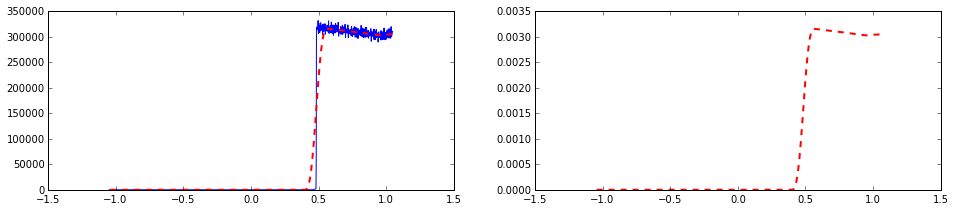

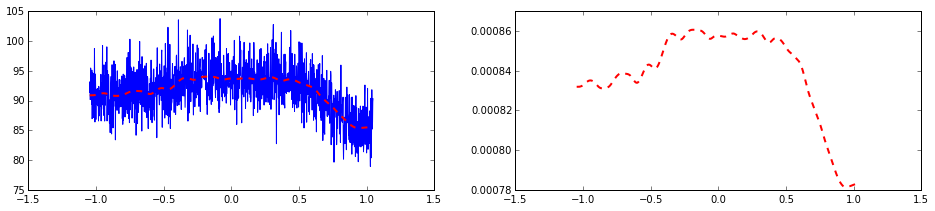

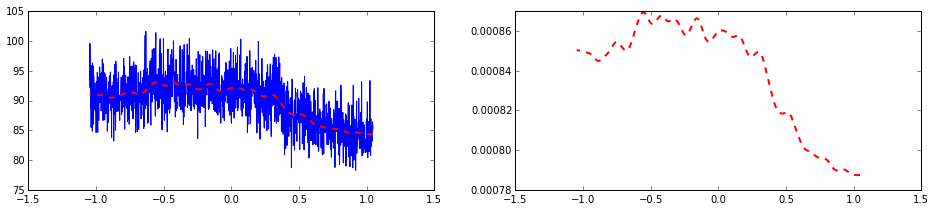

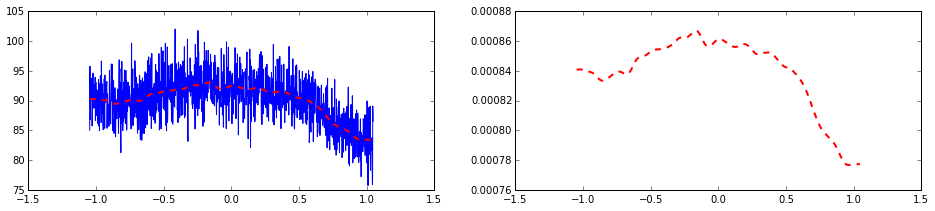

In [26]:
for angles, mp in angles_and_maxpowers0:
    mp_smooth = smoothMaxPower(mp, 100)
    #angles = np.linspace(angles[0], angles[-1], len(mp))
    angles = angles[::-1]
    
    width, height = plt.figaspect(0.2)
    f, axes = plt.subplots(1,2, figsize=(width,height))
    axes[0].plot(angles, mp)
    axes[0].plot(angles, mp_smooth, 'r--', linewidth=2.0)
    #axes[1].plot(angles, 1 - mp/mp.sum())
    axes[1].plot(angles, mp_smooth/mp_smooth.sum(), 'r--', linewidth=2.0)
    #plt.ylim((mp.mean()-3*mp.std(), mp.mean()+3*mp.std()))

In [20]:
#####################################
# Test shielding makes a difference #
#####################################
ham = serial.Serial('/dev/ttyUSB0')
ham.setDTR(0)

p = pyaudio.PyAudio()
duration = 4.0
#play_pure_tone(p, ham, 3000., duration, mag=5.0)
Qout = play_pure_tone_continuously(p, ham, 3000., mag=0.1)

time.sleep(0.2)
sdrs.set_gains(0.1)
sdrs.start_read(0)
time.sleep(duration-0.2)
data = sdrs.stop_read(0)

ham.setDTR(0)
Qout.put("KEYOFF")
Qout.put("EOT")
p.terminate()

Exception


bad: 0


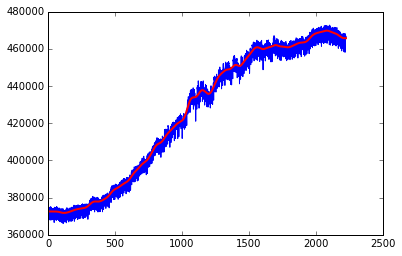

In [21]:
mp = data
good = (abs(mp - mp.mean()) < 3*mp.std())
print('bad: {0}'.format(len(good) - sum(good)))
mp = mp[good]
mp_smooth = smoothMaxPower(mp, 100)# 5*sdrs.fs)

f = plt.figure()
plt.plot(mp, 'b-')
plt.plot(mp_smooth, 'r-', linewidth=2)

#f = plt.figure()
#D = np.fft.fft(data)
#freq = sdrs.fs * np.fft.fftfreq(D.shape[-1])
#b = (abs(freq) < 15000) * (abs(freq) > 100)
#plt.plot(freq[b], abs(D)[b], 'x')